In [1]:
from skimage.morphology import thin
import sys
from pathlib import Path
sys.path.append('..')
from PIL import Image
import numpy as np
from skimage import filters
from skimage import io, color
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.transform import pyramid_gaussian
from skimage import morphology
from skimage import transform
import math
from scipy.ndimage import distance_transform_edt
import pandas as pd


folder = './images_IOSTAR'

list_of_gt = Path(folder).rglob('GT_*.png')
list_of_files = Path(folder).rglob('star*.jpg')
#read files and convert them to numpy arrays
images_gt = []
for file in list_of_gt:
    images_gt.append(np.asarray(Image.open(file)).astype(np.uint8))

images = []
for file in list_of_files:
    images.append(np.asarray(Image.open(file)).astype(np.uint8))

In [2]:
def get_mask(img):
    '''Mask selectionnant seulement les pixels dans le cercle inscrit ci-dessous.'''
    nrows, ncols = img.shape
    row, col = np.ogrid[:nrows, :ncols]

    #On ne considere que les pixels dans le disque inscrit 
    img_mask = (np.ones(img.shape)).astype(np.bool_)
    invalid_pixels = ((row - nrows/2)**2 + (col - ncols/2)**2 > ((nrows - 5)/ 2)**2)
    
    img_mask[invalid_pixels] = 0
    return img_mask

In [3]:
def normalize_min_max(img, mask):
    # Find the minimum and maximum values in the masked image
    masked_image = img * mask
    min_val = np.min(masked_image[np.nonzero(mask)])
    max_val = np.max(masked_image)

    # Normalize the masked region
    normalized_masked_image = (masked_image - min_val) / (max_val - min_val)

    # Reapply the normalized values to the original image
    normalized_image = img.copy()
    normalized_image[mask == 1] = normalized_masked_image[mask == 1] * 255
    return normalized_image

In [4]:
def plot_pyramid(pyramid):
    fig, ax = plt.subplots(1, len(pyramid), figsize=(20, 20))
    for i in range(len(pyramid)):
        ax[i].imshow(pyramid[i]['lapl'], cmap='gray')
        ax[i].axis('off')
        ax[i].set_title(f'Layer {i}')
    plt.show()

In [5]:
def gaussian_pyramid(image, octave, sigma=1.0, order = 3):
    pyramid = []
    h,w = image.shape
    layers = pyramid_gaussian(image, sigma=sigma, max_layer=octave, downscale=2)


    for layer in layers:
        newI = layer
        mask = get_mask(newI)

        entropie = filters.rank.entropy(newI, morphology.disk(2))
        gradient = filters.farid(layer,mask=mask) 
        laplacian = filters.laplace(layer, mask=mask)

        entropie = transform.resize(entropie, (h, w), anti_aliasing=True, order=order)
        gradient = transform.resize(gradient, (h, w), anti_aliasing=True, order=order)
        laplacian = transform.resize(laplacian, (h, w), anti_aliasing=True, order=order)
        
        pyramid.append({'I':newI, 'lapl': laplacian, 'grad': gradient, 'ent': entropie})

    return pyramid

# Analyse exploratoire

## Epaisseur des vaisseaux

#### Analyse des vérités terrain et des squelettes 

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

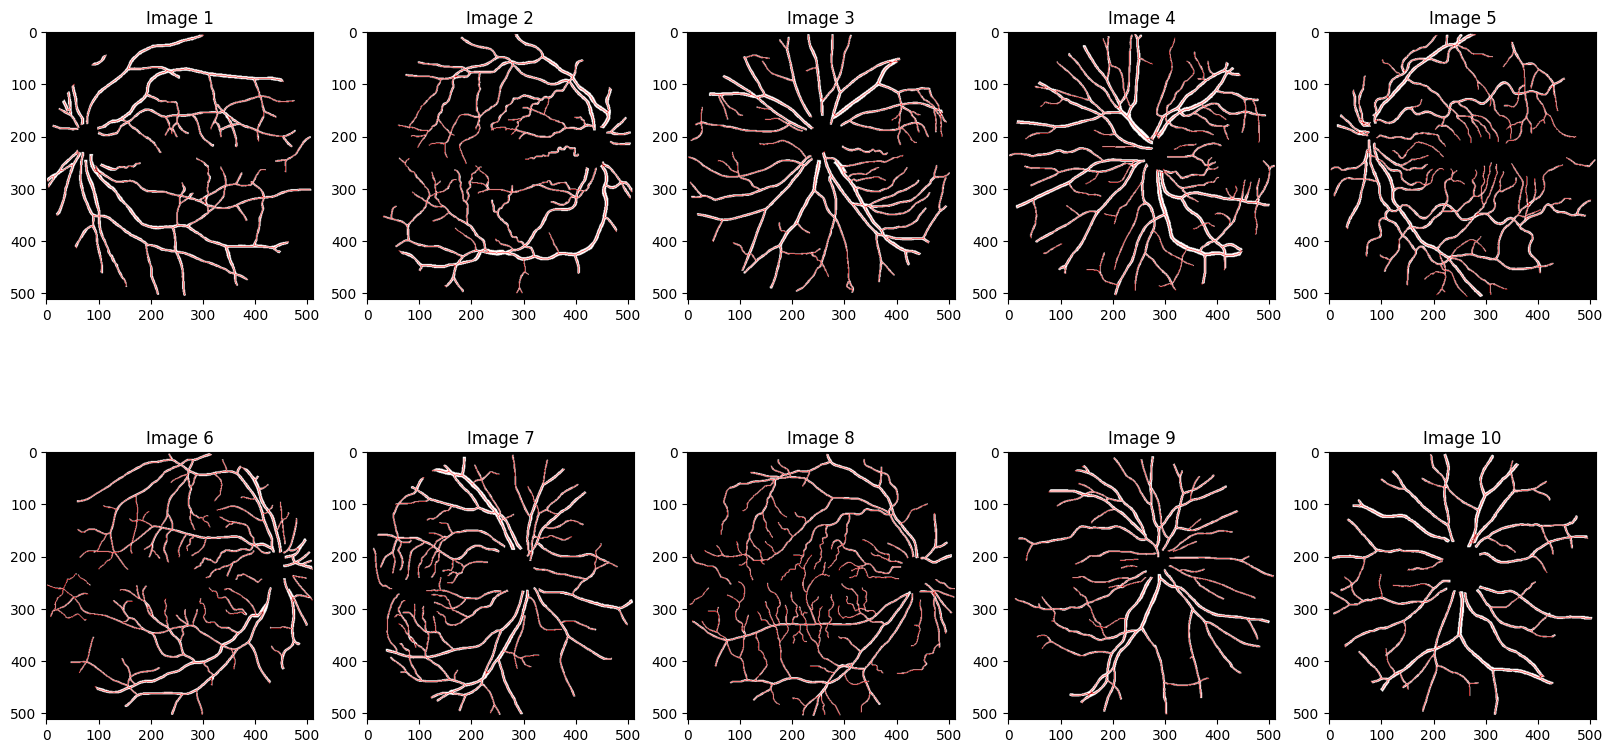

In [6]:
plt.figure(figsize=(20, 10))
for i in range(len(images)):

    GT_skel = thin(images_gt[i], max_num_iter=15)

    img_GT_rgb = np.dstack([images_gt[i]] * 3) * 255
    # Create a copy for overlay
    overlay = img_GT_rgb.copy()
    overlay[GT_skel, 0], overlay[GT_skel,
                                 1], overlay[GT_skel, 2] = 255, 0, 0  # Set red color

    rows = 2
    cols = math.ceil(len(images) / rows)

    plt.subplot(rows, cols, i+1)
    plt.imshow(overlay)
    plt.title(f'Image {i+1}')
plt.tight_layout

#### Calcul des épaisseurs

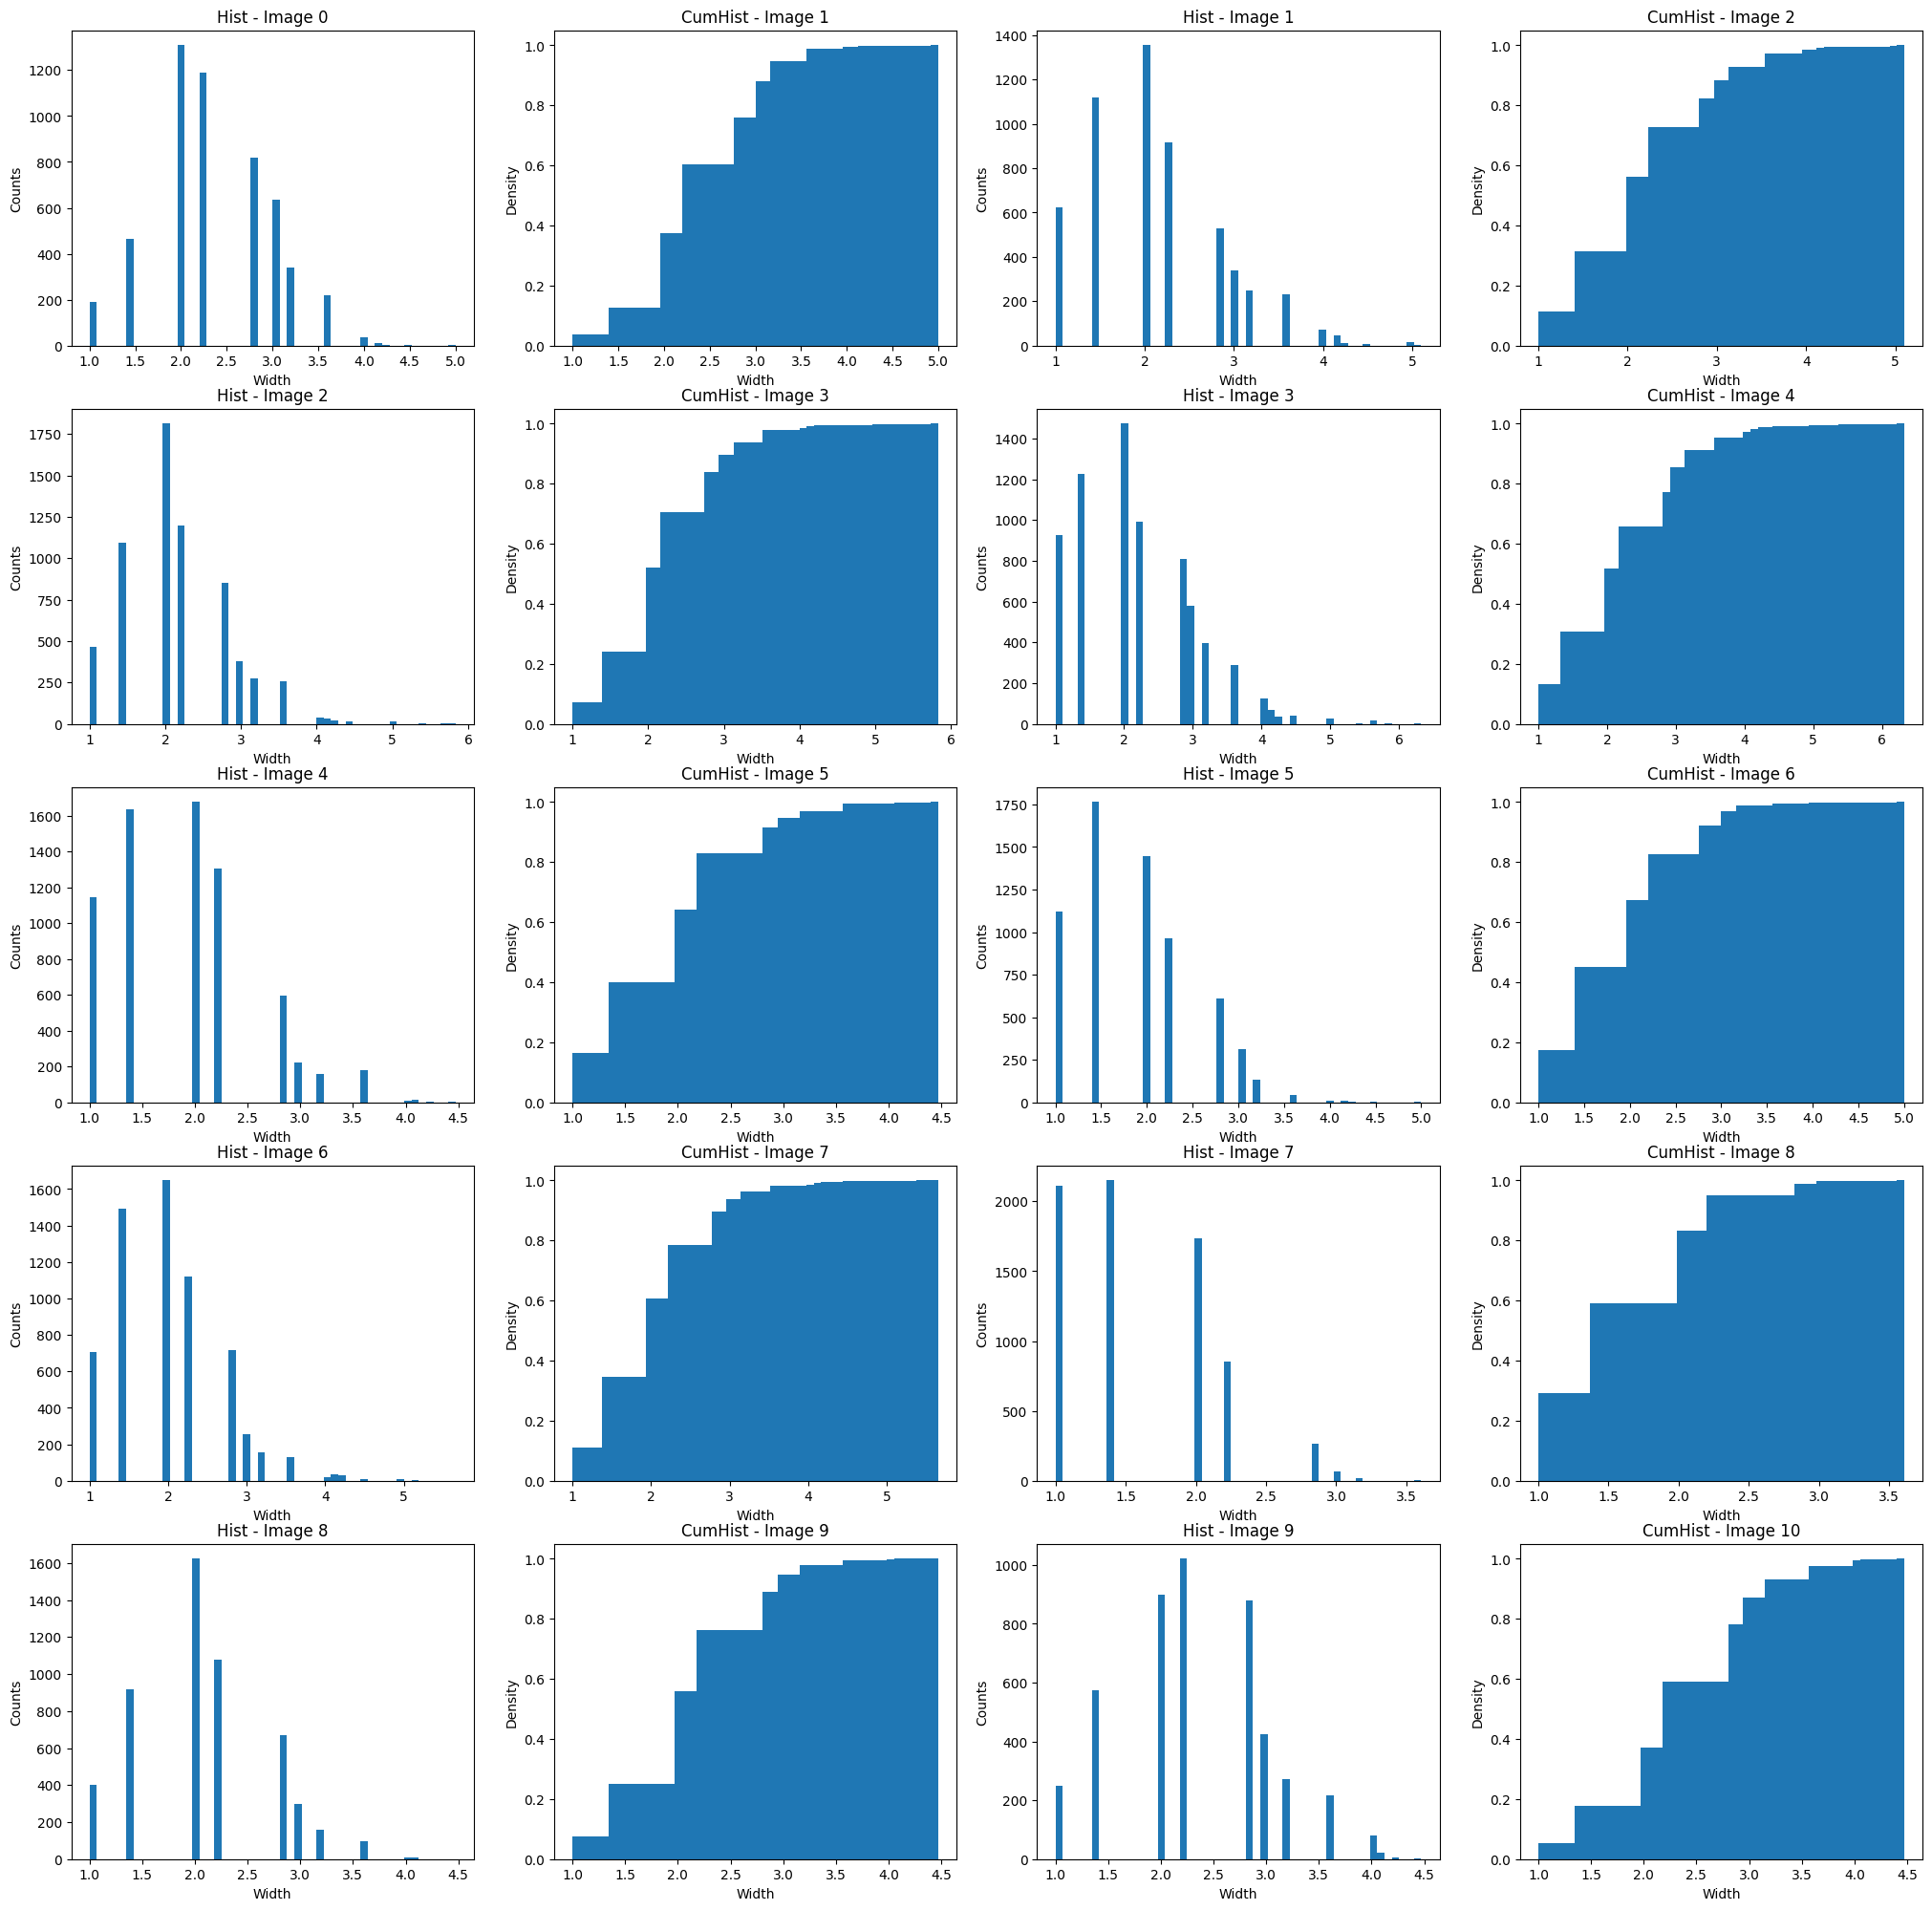

In [7]:
plt.figure(figsize=(25, 30))
cols = 4
rows = math.ceil(len(images) / cols) * 2

for i in range(len(images)):

   distance = distance_transform_edt(images_gt[i])
   GT_skel = thin(images_gt[i], max_num_iter=15)
   vessel_widths = distance[GT_skel]

   plt.subplot(rows, cols, 2*i+1)
   plt.hist(vessel_widths.flatten(), bins=50)
   plt.title(f'Hist - Image {i}')
   plt.xlabel('Width')
   plt.ylabel('Counts')

   plt.subplot(rows, cols, 2*(i+1))
   plt.hist(vessel_widths.flatten(), bins=50, cumulative=True, density=True)
   plt.title(f'CumHist - Image {i+1}')
   plt.xlabel('Width')
   plt.ylabel('Density')

#### Exemple sur la 1ere image

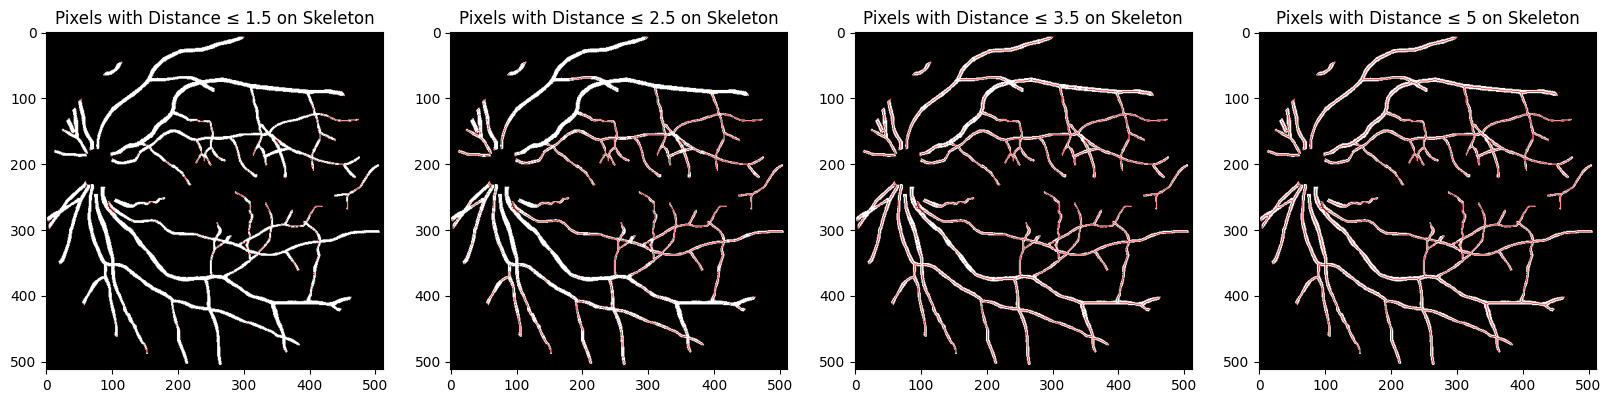

In [8]:
distance = distance_transform_edt(images_gt[0]).astype(np.float32)
GT_skel = thin(images_gt[0], max_num_iter=15)
Dist_Thd = [1.5, 2.5, 3.5, 5]

plt.figure(figsize=(20, 5))
for d_idx, d in enumerate(Dist_Thd, start=1):
   mask_distance_leq = (distance <= d) & GT_skel

   img_GT_rgb = np.stack((images_gt[0], images_gt[0], images_gt[0]),
                         axis=-1).astype(np.uint8) * 255
   img_GT_rgb[mask_distance_leq] = [255, 0, 0]  # Red color

   # Ensure the image to plot is uint8
   img_GT_rgb = img_GT_rgb.astype(np.uint8)

   # Now plot
   plt.subplot(1, len(Dist_Thd), d_idx)
   plt.imshow(img_GT_rgb)
   plt.title(f'Pixels with Distance ≤ {d} on Skeleton')

## Analyse du niveau de gris

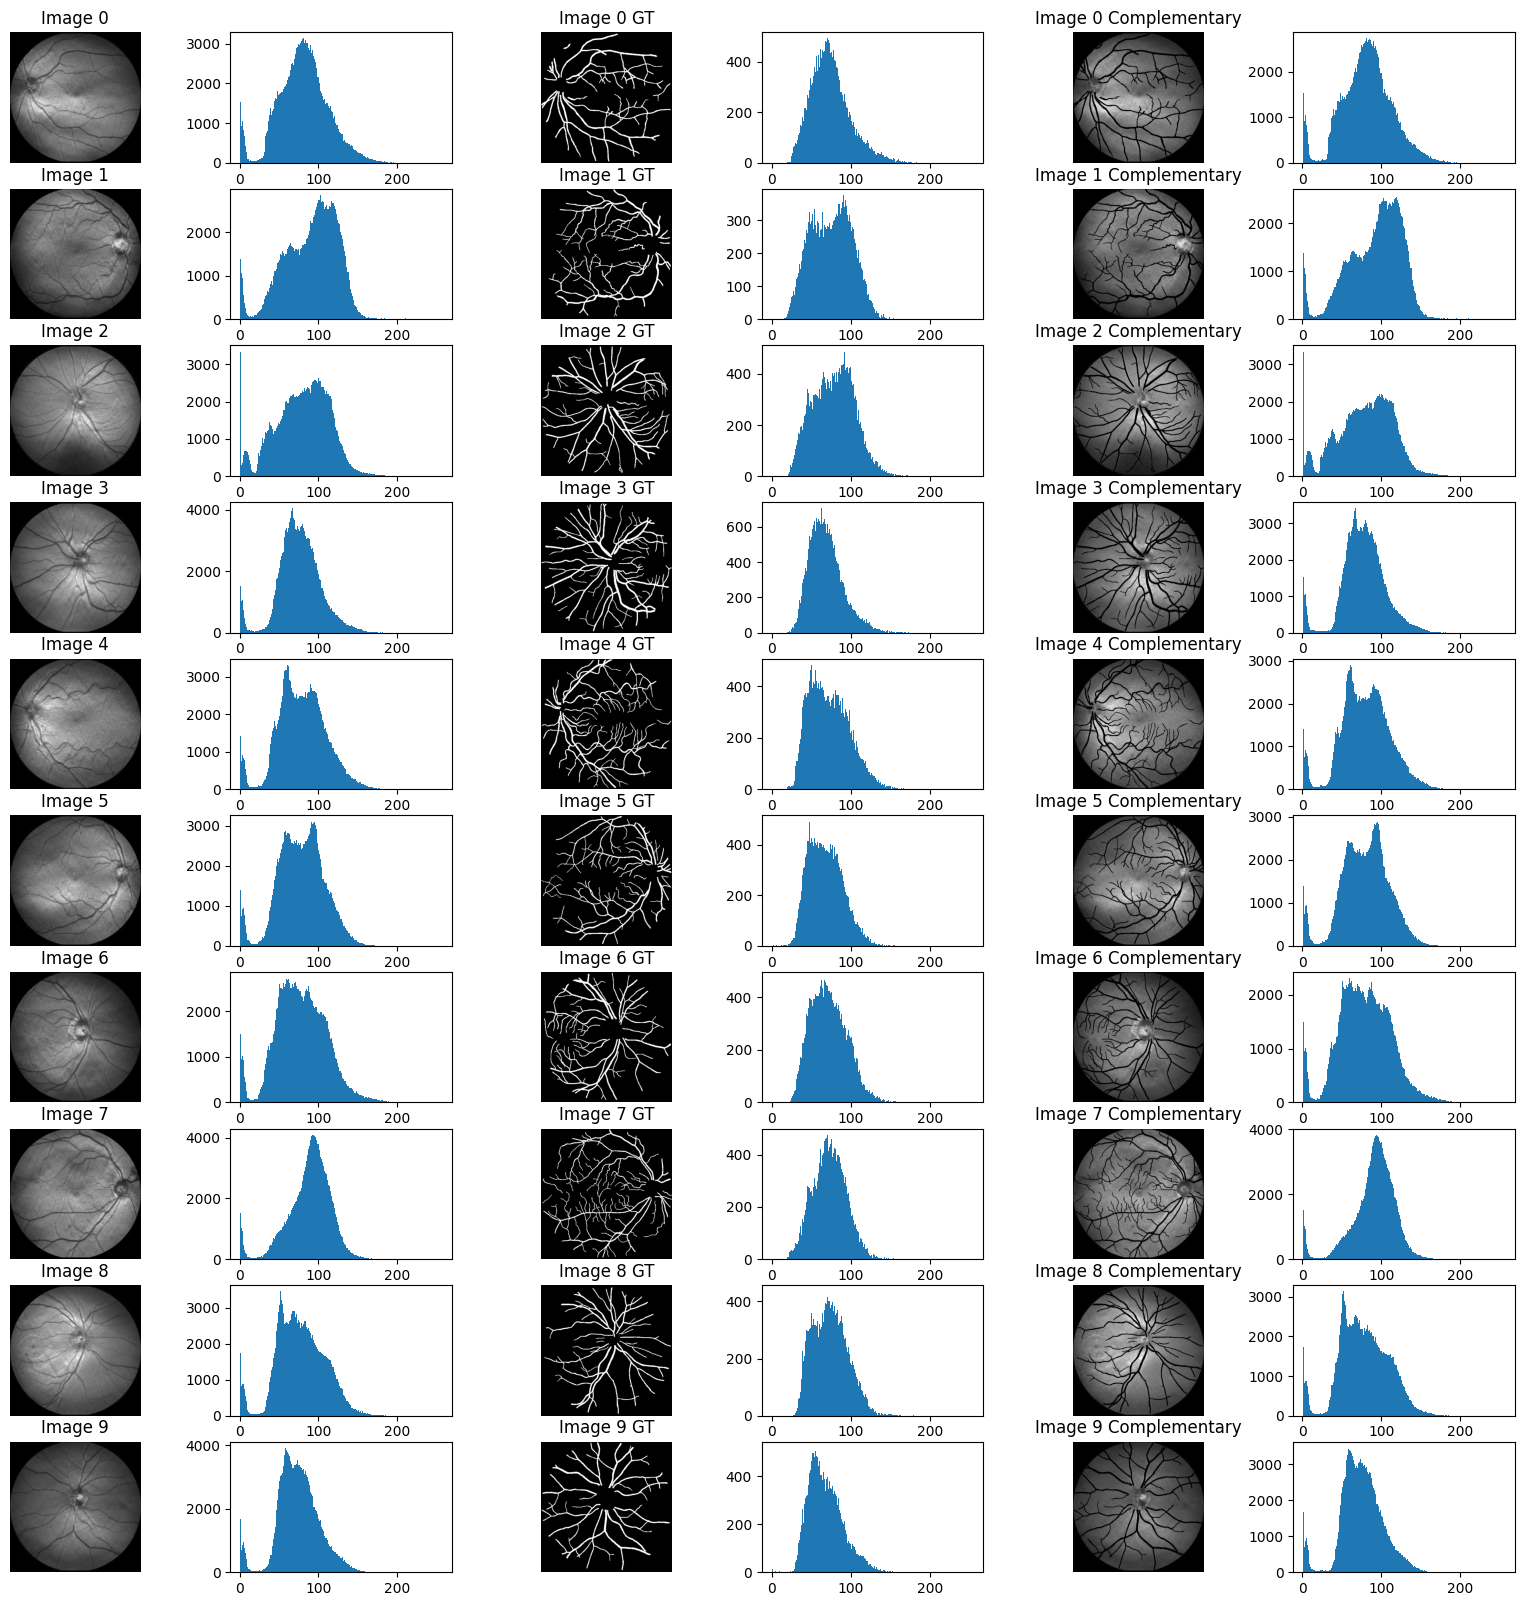

In [9]:
# display images
Min_image_pixels = 256

plt.figure(figsize=(20, 20))

for i in range(len(images)):
    plt.subplot(10, 6, 6*i+1)
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Image {i}')

    # plot histogram of the image
    plt.subplot(10, 6, 6*i+2)
    plt.hist(images[i].ravel(), bins=256, range=(
        1, 256))  # J'enlève la valeur 0 car biaise le plot !

    plt.subplot(10, 6, 6*i+3)
    plt.imshow(images_gt[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Image {i} GT')

    # plot histogram of the pixel of the original image that match the mask
    plt.subplot(10, 6, 6*i+4)
    image_pixels = images[i][images_gt[i] > 0]
    plt.hist(image_pixels, bins=256, range=(0, 255))

    # Calculate and display complementary of the mask
    plt.subplot(10, 6, 6*i+5)
    comp_img = np.where(images_gt[i], 0, images[i])
    plt.imshow(comp_img, cmap='gray')
    plt.axis('off')
    plt.title(f'Image {i} Complementary')

    # Plot histogram for the complementary of the mask
    plt.subplot(10, 6, 6*i+6)
    plt.hist(comp_img.ravel(), bins=256, range=(
        1, 256))  # Idem on enlève 0 car trop de points

# Algorithme de séparation des veines du fond occulaire

In [10]:
def my_segmentation(img,sigma=2.3,upscale_factor=7, octave=3, order =3, mS=60, Connect=0, ds=0):
    # Increase image size
    h,w = img.shape
    #Preprocessing
    img = normalize_min_max(img, get_mask(img))
    img = transform.resize(img, (h*upscale_factor, w*upscale_factor), anti_aliasing=True, order=order)

    #feature extraction
    pyramid = gaussian_pyramid(img,sigma=sigma, octave=octave, order=order)
    laplacian = np.zeros((h*upscale_factor,w*upscale_factor))
    for i in range(len(pyramid)):

        laplacian += pyramid[i]['lapl']
    l_resized = transform.resize(laplacian, (h, w), anti_aliasing=True, order=order)

    # segmentation (thresholding)
    thd = filters.threshold_otsu(l_resized)
    binary = l_resized > thd

    out11 = morphology.closing(~binary, morphology.disk(ds))

    out = morphology.remove_small_objects(
        out11, min_size=mS, connectivity=Connect)
    
    return out

In [11]:
def my_evaluate(img, binary, GT):
    from script_tp2 import evaluate
    ACCU, RECALL, img_out_skel, GT_skel = evaluate(binary, GT)
    plt.figure(figsize=(8, 3))
    plt.subplot(1,4,1)
    plt.imshow(color.label2rgb(img_out_skel, img, bg_label=-1, alpha=0.5))
    plt.title('Image skeleton')
    plt.axis('off')

    plt.subplot(1,4,2)
    plt.imshow(GT_skel, cmap='binary')
    plt.title('GT skeleton')
    plt.axis('off')
    #plt.show()

    plt.subplot(1,4,3)
    plt.imshow(GT_skel & ~binary, cmap='binary')
    plt.title('False negative')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(img_out_skel & ~GT, cmap='binary')
    plt.title('False positive')
    plt.axis('off')

    plt.show()

    #print(f'Accuracy: {ACCU}')

    #print(f'Recall: {RECALL}')
    return ACCU, RECALL

In [12]:
def run_eval():
   p_mem, r_mem = [], []
   for i in range(len(images)):
      edge = my_segmentation(images[i])
      p, r = my_evaluate(images[i], edge, images_gt[i])
      p_mem.append(p)
      r_mem.append(r)

   image_ids = [f'Img{i+1}' for i in range(10)]
   results_dict = {image_id: [round(p_mem[i],2), round(r_mem[i],2)]
                   for i, image_id in enumerate(image_ids)}
   
   results_dict['Mean Performance'] = [round(np.mean(p_mem),2), round(np.mean(r_mem),2)]
   results_dict['Std Performance'] = [round(np.std(p_mem),2), round(np.std(r_mem),2)]

   # Create a DataFrame from the dictionary
   results_df = pd.DataFrame(results_dict, index=['Preci', 'Recall'])

   # Transpose the DataFrame to have images as columns and precision/recall as rows

   results_str = results_df.to_string()
   print(results_str)

   #print(f"total precision {np.mean(p_mem)} +/- {np.std(p_mem)}")
   #print(f"total precision {np.mean(r_mem)} +/- {np.std(r_mem)}")

# Choix de la normalisation

In [13]:
def normalize_mean_std(img,mask):
    masked_image = img * mask
    mean = np.mean(masked_image[np.nonzero(mask)])
    std = np.std(masked_image[np.nonzero(mask)])

    normalized_masked_image = (masked_image - mean) / std

    return normalized_masked_image

Text(0.5, 1.0, 'Normalized image with mean and std')

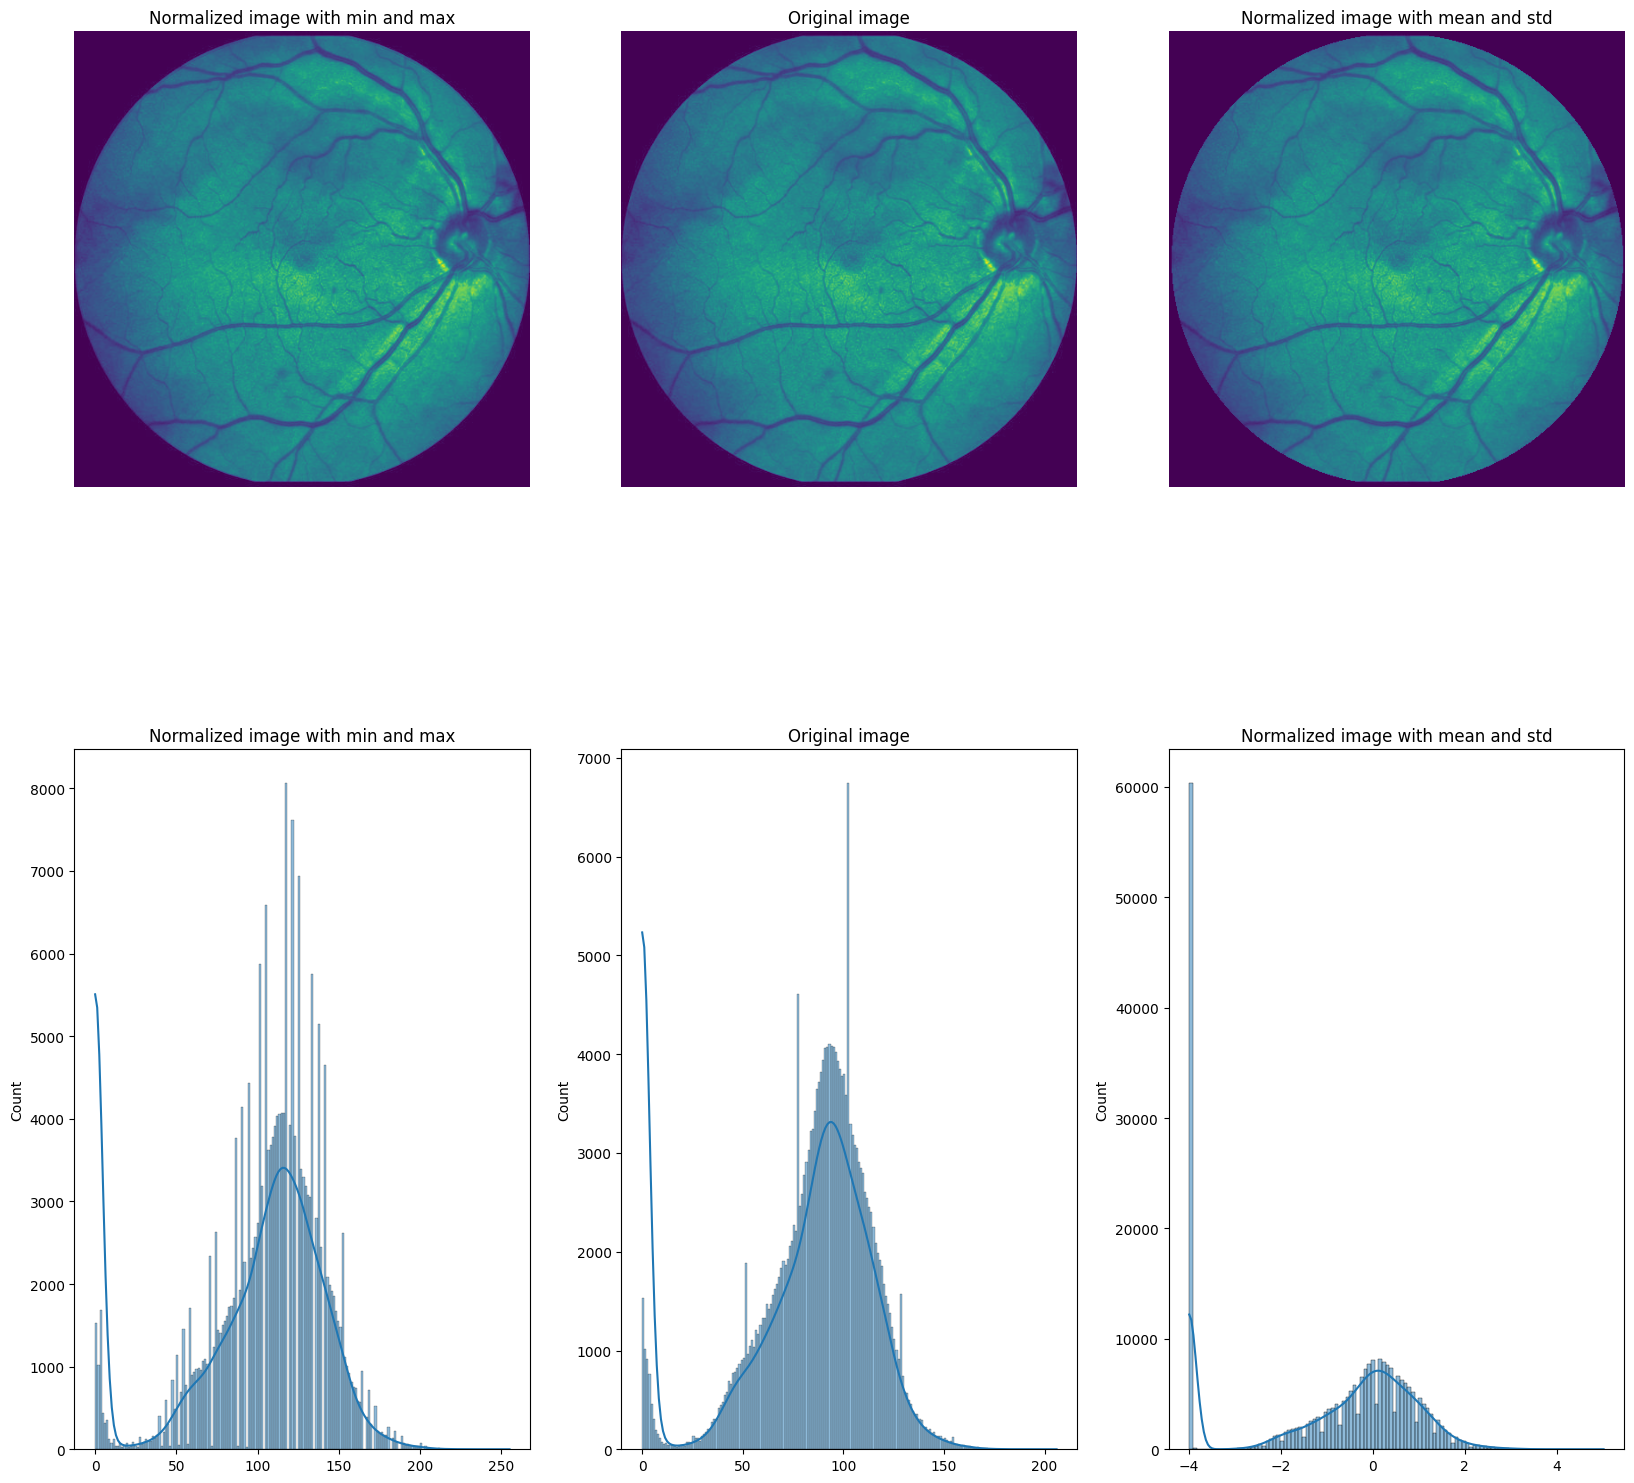

In [14]:
img = images[7]
mask = get_mask(img)
img_n_min_max = normalize_min_max(img, mask)
img_n_mean_std = normalize_mean_std(img, mask)
plt.figure(figsize=(20,20))
plt.subplot(2,3,1)
plt.imshow(img_n_min_max)
plt.axis('off')
plt.title('Normalized image with min and max')


plt.subplot(2,3,2)
plt.imshow(img)
plt.axis('off')
plt.title('Original image')

plt.subplot(2,3,3)
plt.imshow(img_n_mean_std)
plt.axis('off')
plt.title('Normalized image with mean and std')

plt.subplot(2,3,4)
sns.histplot(img_n_min_max.ravel(),binrange=[0.01, np.max(img_n_min_max)], kde=True)
plt.title('Normalized image with min and max')

plt.subplot(2,3,5)
sns.histplot(img.ravel(),binrange=[0.01, np.max(img)], kde=True)
plt.title('Original image')

plt.subplot(2,3,6)
sns.histplot(img_n_mean_std.ravel(),binrange=[np.min(img_n_mean_std), np.max(img_n_mean_std)], kde=True)
plt.title('Normalized image with mean and std')

# Sur échantillonage

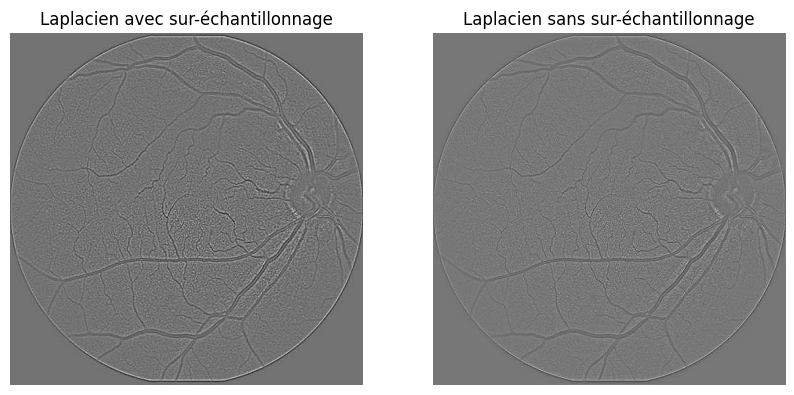

energy of the upscale image: -1.7763568394002505e-15
energy of the original image: -4.085620730620576e-14


In [15]:
img = images[7]
mask = get_mask(img)

h,w = img.shape

img_upscale = transform.resize(img, (h*7, w*7), anti_aliasing=True, order=1)
laplacian_upscale = np.zeros(img.shape)
for layer in pyramid_gaussian(img_upscale, max_layer=3, downscale=2):
    layer = transform.resize(layer, (h, w), anti_aliasing=True, order=1)
    laplacian_upscale += filters.laplace(layer)
    

laplacian_origin = np.zeros(img.shape)
for layer in pyramid_gaussian(img, max_layer=3, downscale=2):
    layer = transform.resize(layer, (h, w), anti_aliasing=True, order=1)
    laplacian_origin += filters.laplace(layer)


plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(laplacian_upscale, cmap='gray')
plt.axis('off')
plt.title('Laplacien avec sur-échantillonnage')

plt.subplot(1,2,2)
plt.imshow(laplacian_origin, cmap='gray')
plt.axis('off')
plt.title('Laplacien sans sur-échantillonnage')
plt.show()




print(f'energy of the upscale image: {np.sum(laplacian_upscale)}')
print(f'energy of the original image: {np.sum(laplacian_origin)}')

# Extraction de charactéristique

### Entropie, gradient et laplacien avec seuillage.

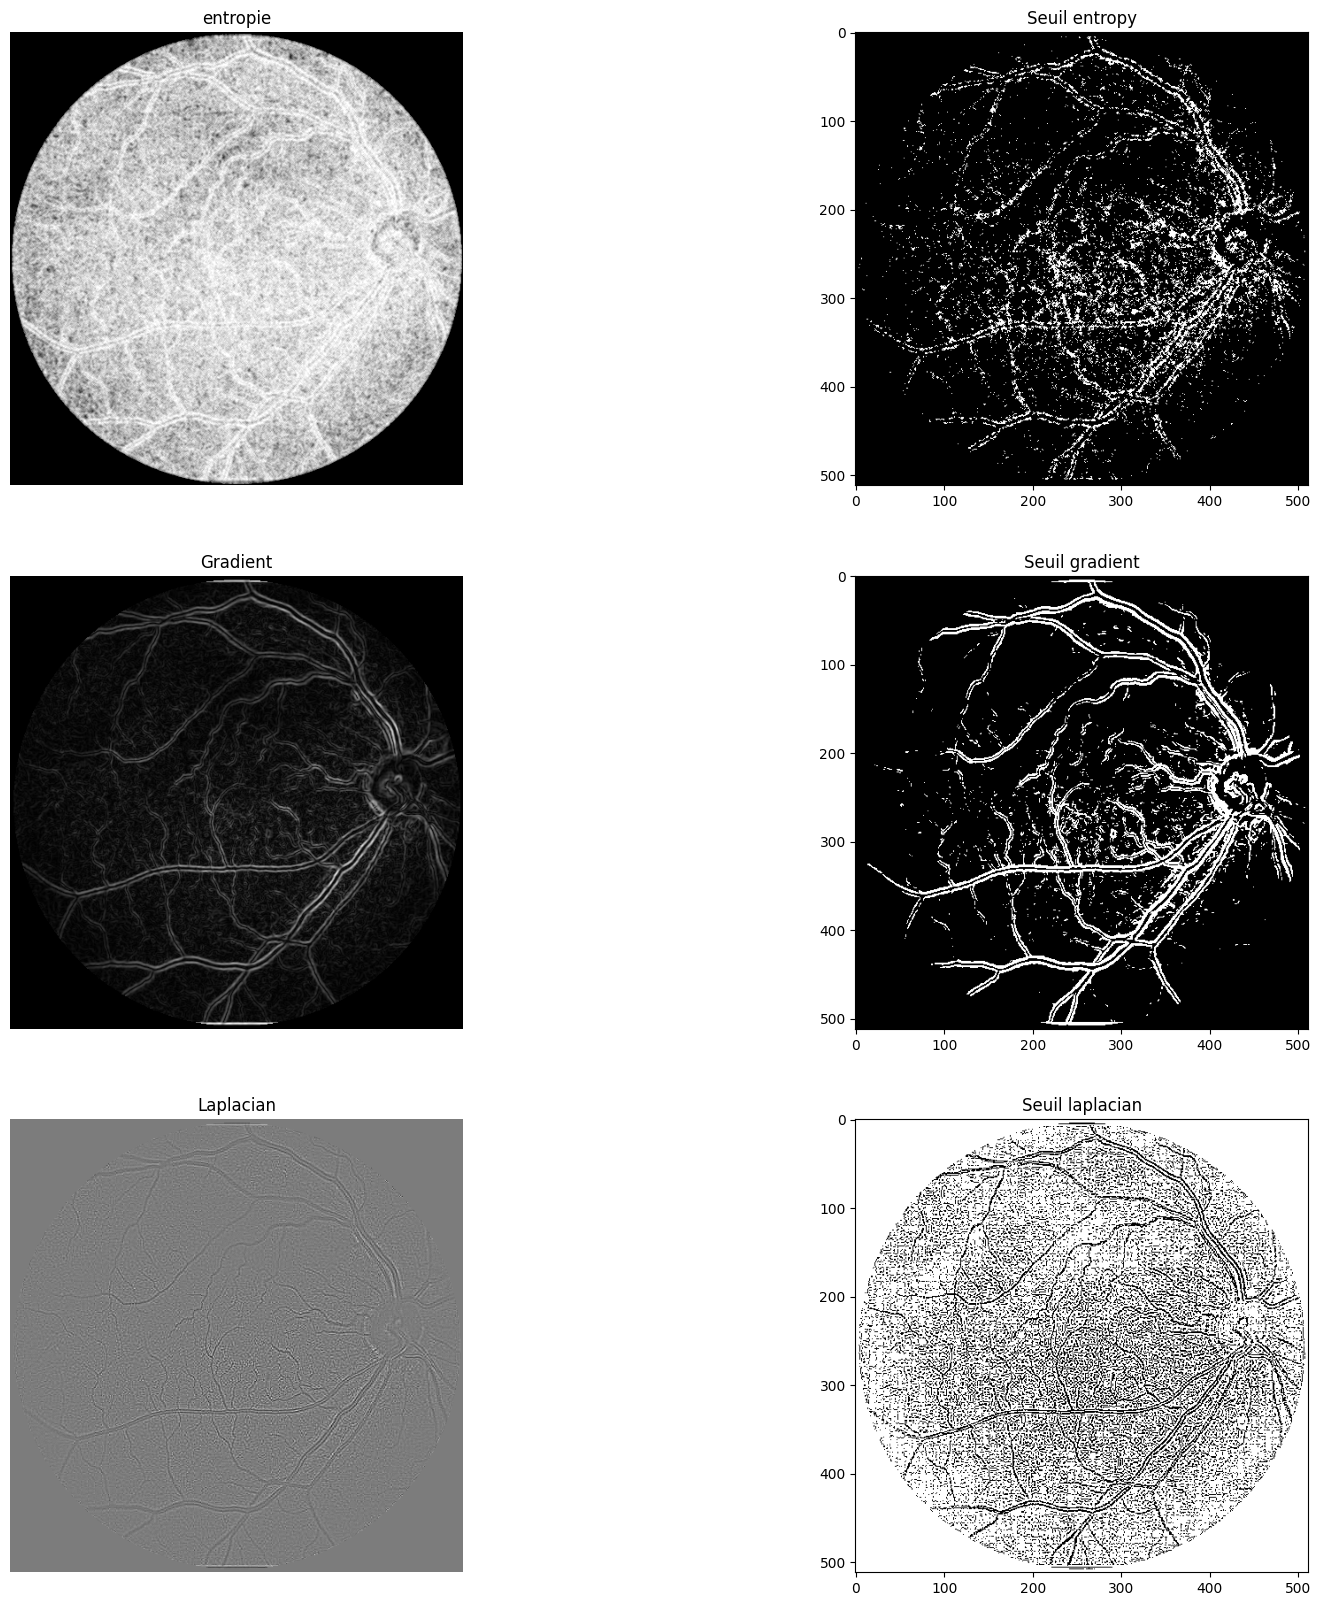

In [16]:
from skimage.filters.rank import entropy
from skimage.morphology import disk
img = images[7]
mask = get_mask(img)

img_normalize = normalize_min_max(img, mask)
entropy_value = entropy(img_normalize, disk(2), mask=mask)
gradient = filters.farid(img,mask=mask)
laplacian = filters.laplace(img, mask=mask)


plt.figure(figsize=(20,20))
plt.subplot(3,2,1)
plt.imshow(entropy_value, cmap='gray')
plt.axis('off')
plt.title('entropie')

plt.subplot(3,2,2)
plt.imshow(entropy_value > np.percentile(entropy_value, 90), cmap='gray')
plt.title('Seuil entropy')

plt.subplot(3,2,3)
plt.imshow(gradient, cmap='gray')
plt.axis('off')
plt.title('Gradient')

plt.subplot(3,2,4)
plt.imshow(gradient > filters.threshold_otsu(gradient), cmap='gray')
plt.title('Seuil gradient')

plt.subplot(3,2,5)
plt.imshow(laplacian, cmap='gray')
plt.axis('off')
plt.title('Laplacian')

plt.subplot(3,2,6)
plt.imshow(laplacian > filters.threshold_otsu(laplacian), cmap='gray')
plt.title('Seuil laplacian')


plt.show()


## Réponse impulsionelle des opérateur de gradients

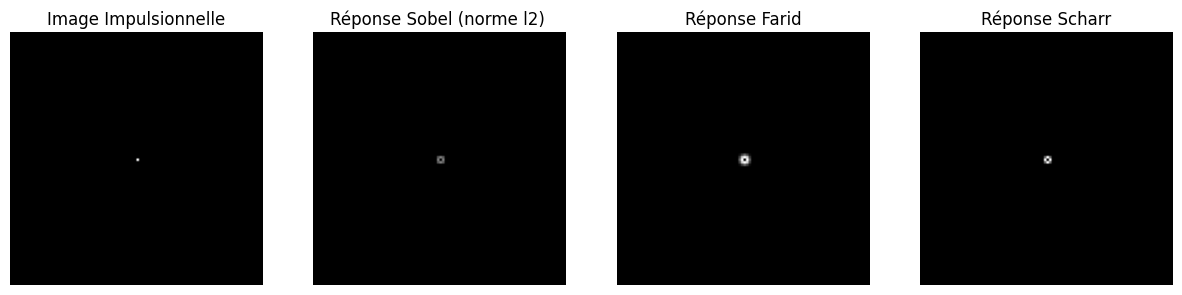

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import sobel_h, sobel_v
from skimage import data

# Étape 1: Créer une image impulsionnelle
image_delta = np.zeros((100, 100), dtype=np.float32)
image_delta[50, 50] = 1  # Impulsion au centre

sobel_h_response = sobel_h(image_delta)
sobel_v_response = sobel_v(image_delta)

farid = filters.farid(image_delta)

# Compute the gradient using the Scharr filter
gradient_scharr = filters.scharr(image_delta)

# Étape 3: Visualiser la réponse impulsionnelle
fig, ax = plt.subplots(1, 4, figsize=(15, 20))
ax = ax.ravel()
ax[0].imshow(image_delta, cmap='gray')
ax[0].set_title('Image Impulsionnelle')
ax[0].axis('off')

ax[1].imshow(np.sqrt(sobel_h_response*sobel_h_response + sobel_v_response*sobel_v_response), cmap='gray', vmin=0, vmax=1)
ax[1].set_title('Réponse Sobel (norme l2) ')
ax[1].axis('off')

ax[2].imshow(farid, cmap='gray')
ax[2].set_title('Réponse Farid')
ax[2].axis('off')

ax[3].imshow(gradient_scharr, cmap='gray')
ax[3].set_title('Réponse Scharr')
ax[3].axis('off')



plt.show()


## Réponse impulsionelle laplacien et LoG

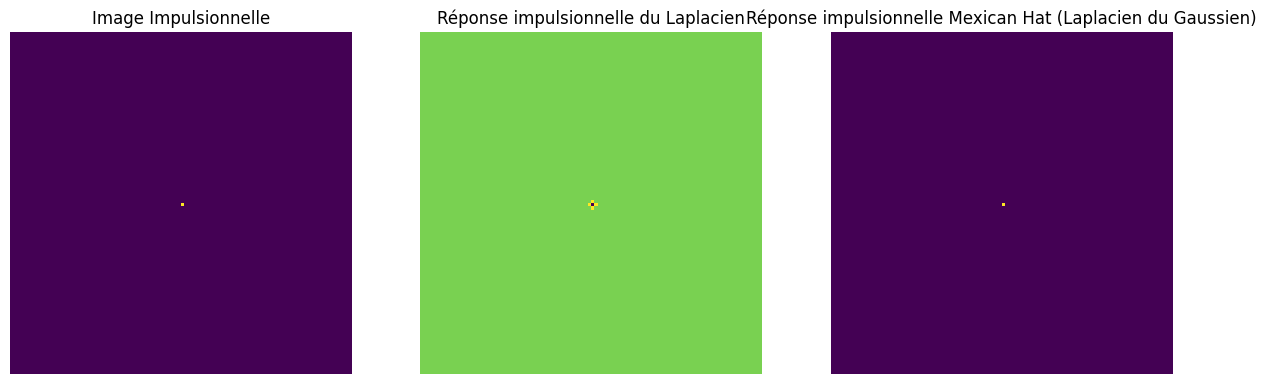

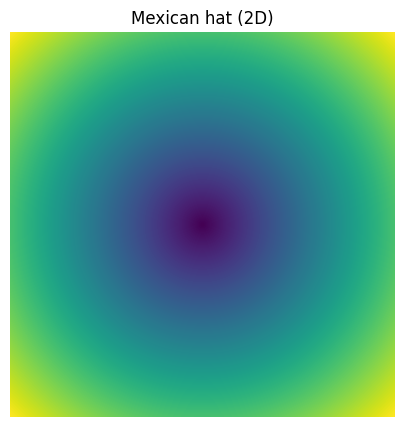

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_laplace

# Créer un signal d'impulsion 2D (une matrice avec une valeur 1 au centre)
image_delta = np.zeros((100, 100), dtype=np.float32)
image_delta[50, 50] = 1  # Impulsion au centre

# Définir le noyau Laplacien
laplacien_kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])

# Appliquer le noyau à l'impulsion via convolution
reponse_impulsionnelle = convolve2d(image_delta, laplacien_kernel, mode='same')

# Appliquer la fonction Mexican Hat (Laplacien du Gaussien)
sigma = 2.0 # Écart-type du Gaussien
Z = -1/(np.pi*sigma**4) * (1 - (image_delta**2)/(2*sigma**2)) * np.exp(-image_delta**2/(2*sigma**2))

fig, ax = plt.subplots(1, 3, figsize=(15, 20))
ax = ax.ravel()
ax[0].imshow(image_delta)
ax[0].set_title('Image Impulsionnelle')
ax[0].axis('off')

# Afficher la réponse impulsionnelle
im  = ax[1].imshow(reponse_impulsionnelle)
ax[1].axis('off')

ax[1].set_title('Réponse impulsionnelle du Laplacien')

ax[2].imshow(Z)
ax[2].set_title('Réponse impulsionnelle Mexican Hat (Laplacien du Gaussien)')
ax[2].axis('off')
plt.show()

# Générer une grille de points
x = np.linspace(-10, 10, 400)
y = np.linspace(-10, 10, 400)
X, Y = np.meshgrid(x, y)

# Calculer le rayon à partir du centre
R = np.sqrt(X**2 + Y**2)
plt.figure(figsize=(5,5))
plt.imshow(R,  extent=(x.min(), x.max(), y.min(), y.max()))
plt.axis('off')
plt.title('Mexican hat (2D)')
plt.show()


### Multiscale

C:\Users\marce\AppData\Local\Temp\ipykernel_11472\3592362711.py:2: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  pyra = gaussian_pyramid(img, octave = 3, sigma=1, order=3)


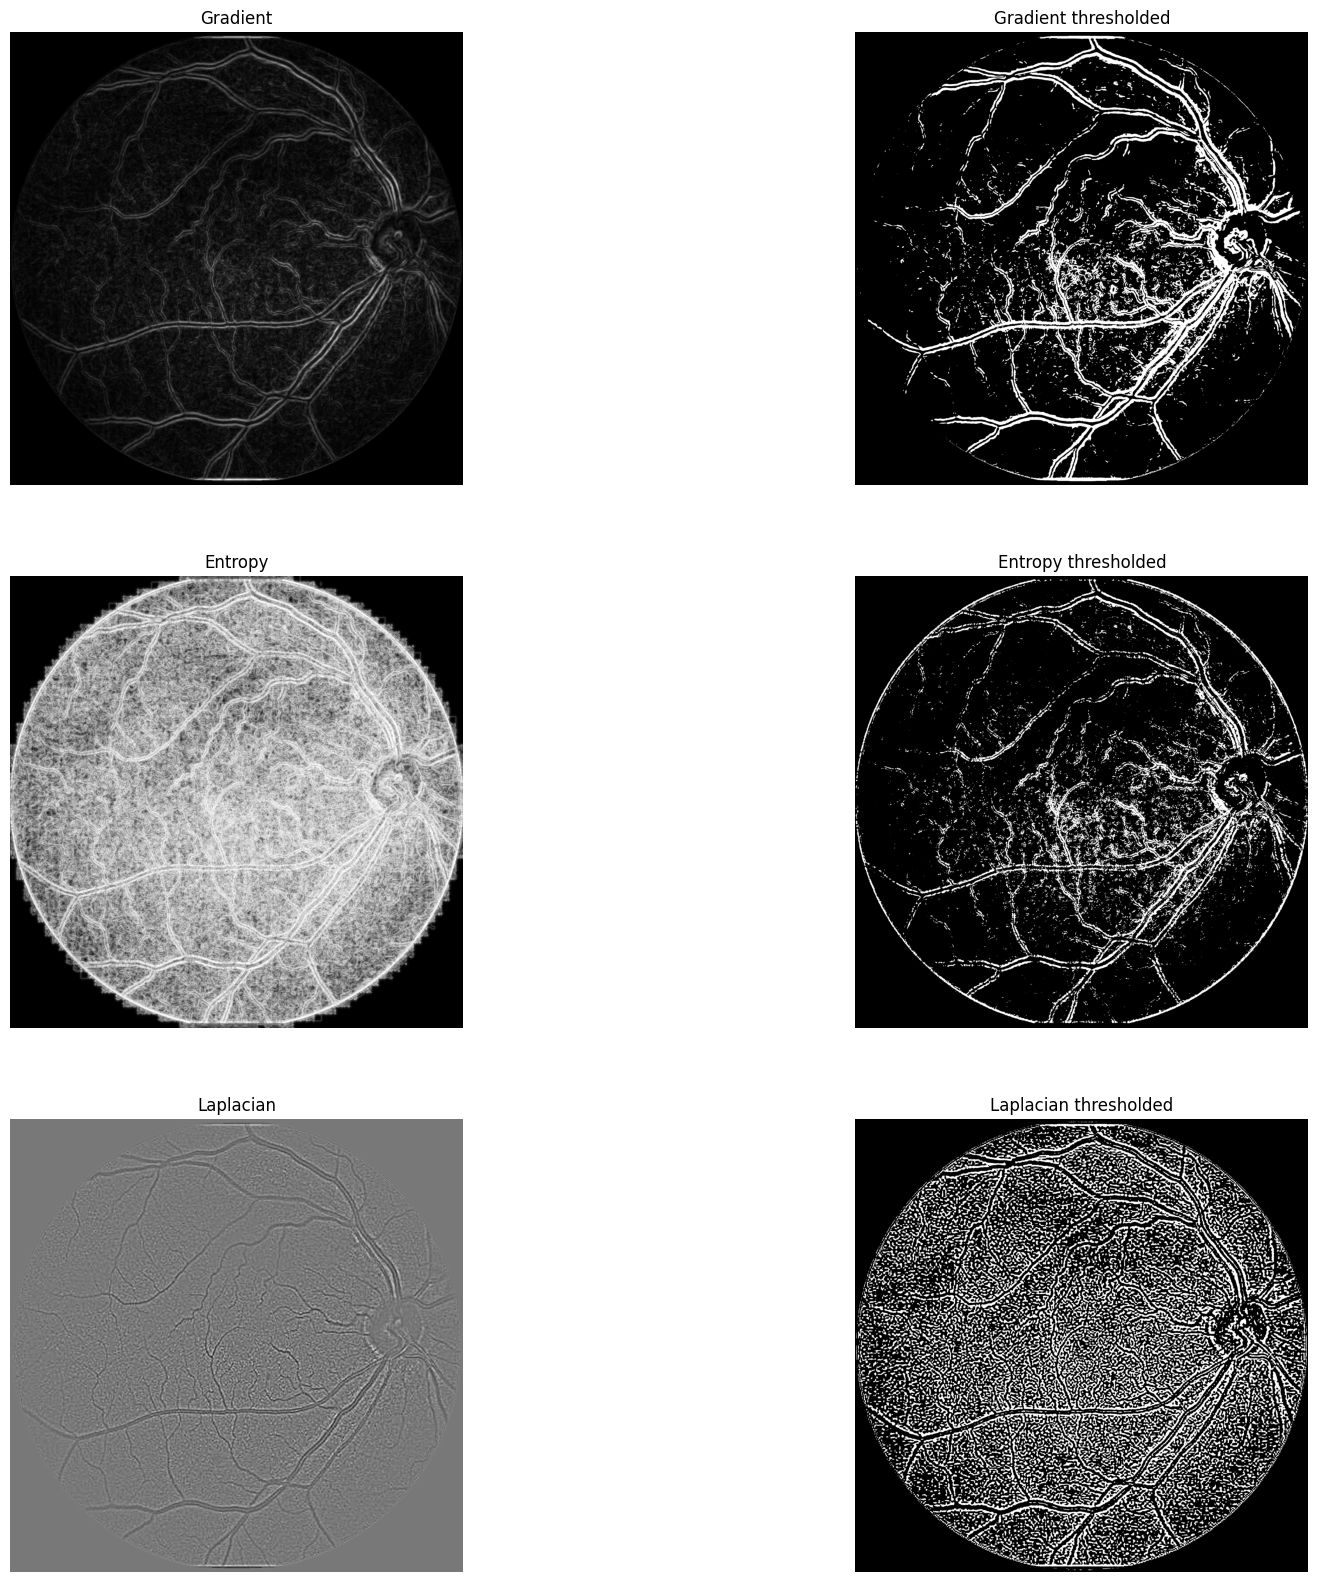

In [23]:

#multiscale
pyra = gaussian_pyramid(img, octave = 3, sigma=1, order=3)

gradient = np.zeros(img.shape)
entropy = np.zeros(img.shape)
laplacian = np.zeros(img.shape)
for i in range(len(pyra)):
    gradient += pyra[i]['grad']
    entropy += pyra[i]['ent']
    laplacian += pyra[i]['lapl']

plt.figure(figsize=(20,20))
plt.subplot(3,2,1)
plt.imshow(gradient, cmap='gray')
plt.axis('off')
plt.title('Gradient')

plt.subplot(3,2,2)
plt.imshow(gradient>filters.threshold_otsu(gradient), cmap='gray')
plt.axis('off')
plt.title('Gradient thresholded')

plt.subplot(3,2,3)
plt.imshow(entropy, cmap='gray')
plt.axis('off')
plt.title('Entropy')

plt.subplot(3,2,4)
plt.imshow(entropy> np.percentile(entropy, 90), cmap='gray')
plt.axis('off')
plt.title('Entropy thresholded')

plt.subplot(3,2,5)
plt.imshow(laplacian, cmap='gray')
plt.axis('off')
plt.title('Laplacian')

plt.subplot(3,2,6)
plt.imshow(laplacian>filters.threshold_otsu(laplacian), cmap='gray')
plt.axis('off')
plt.title('Laplacian thresholded')

plt.show()

C:\Users\marce\AppData\Local\Temp\ipykernel_11472\2205223221.py:9: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  pyramid = gaussian_pyramid(img,sigma=sigma, octave=octave, order=order)


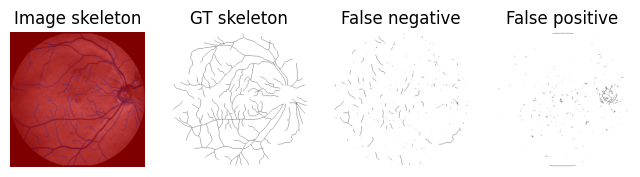

In [24]:
edge = my_segmentation(images[7])
p, r = my_evaluate(images[7], edge, images_gt[7])

# Seuillage

C:\Users\marce\AppData\Local\Temp\ipykernel_11472\1957291789.py:7: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  pyramid = gaussian_pyramid(img,sigma=sigma, octave=octave, order=order)


(-0.09, 0.09)

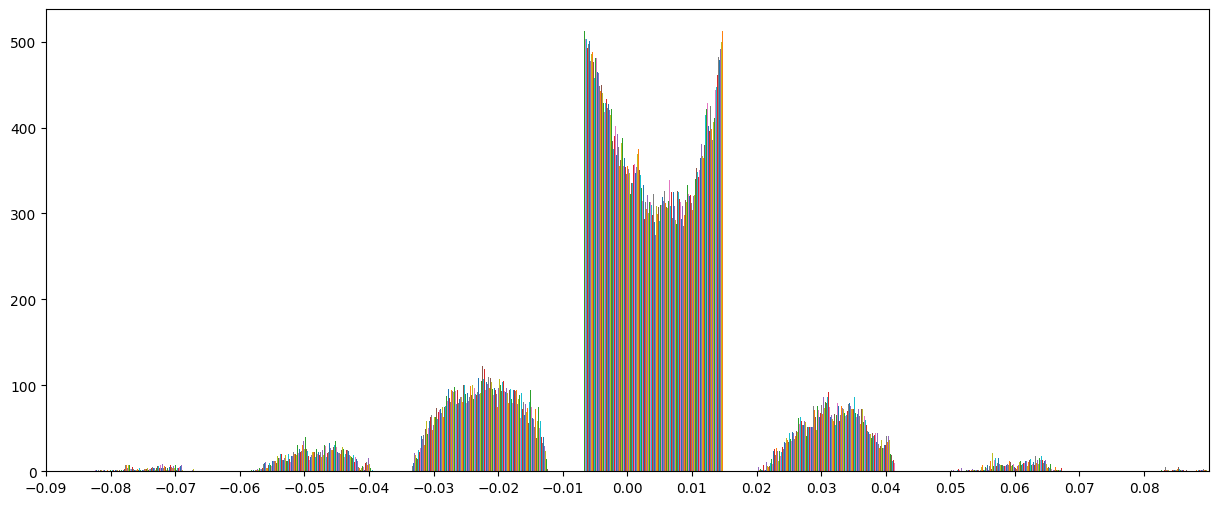

In [20]:
sigma, octave, order, upscale_factor = 2.3, 3, 3, 7

img = images[7]
img = normalize_min_max(img, get_mask(img))
img = transform.resize(img, (h*upscale_factor, w*upscale_factor), anti_aliasing=True, order=order)

pyramid = gaussian_pyramid(img,sigma=sigma, octave=octave, order=order)
laplacian = np.zeros((h*upscale_factor,w*upscale_factor))
for i in range(len(pyramid)):
   laplacian += pyramid[i]['lapl']
l_resized = transform.resize(laplacian, (h, w), anti_aliasing=True, order=order)

plt.figure(figsize=(15,6))
plt.hist(l_resized, )
tick_values = np.arange(-0.09, 0.09, 0.01)
plt.xticks(tick_values)
plt.xlim(-0.09, 0.09)

Threshold -0.009311142677734467 0.0011728503535440027


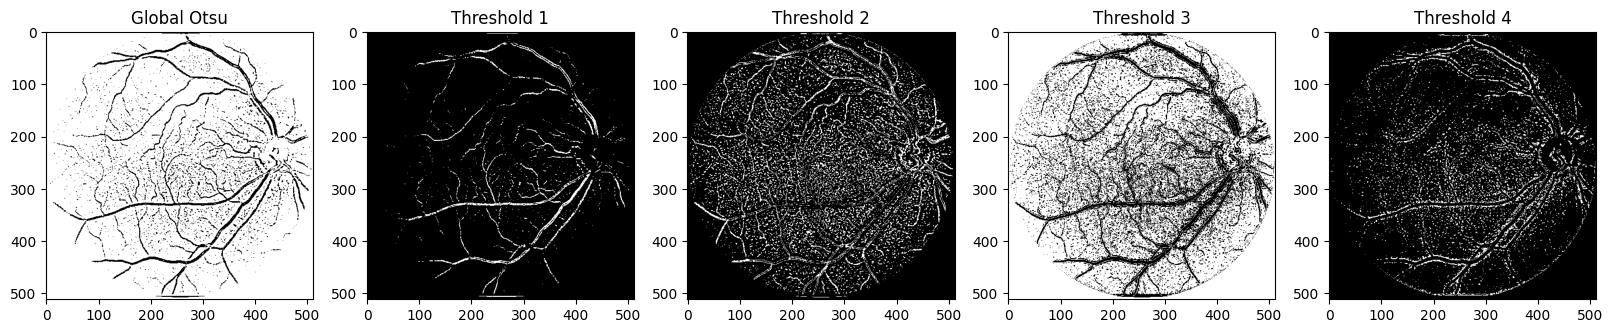

In [21]:
thd = filters.threshold_otsu(l_resized)
th1 = filters.threshold_triangle(l_resized)
print("Threshold", thd, th1)
binary_global = l_resized > 2 * thd

Thds = [-0.035, -0.01, 0.02, 0.05]

plt.figure(figsize=(20, 20))
# Add the global threshold binary image as the first subplot
plt.subplot(1, len(Thds) + 1, 1)
plt.imshow(binary_global, cmap='gray')
plt.title("Global Otsu")

# start=1 to correctly set subplot indices
for idx, threshold in enumerate(Thds, start=1):
    plt.subplot(1, len(Thds) + 1, idx + 1)  # Adjust subplot index
    if idx == 1:
        binary = l_resized < threshold
    else:
        binary = (l_resized > Thds[idx - 2]) & (l_resized <= threshold)
    plt.imshow(binary, cmap='gray')
    plt.title(f"Threshold {idx}")

# Post processing

Cf extraction de characteristique

# Eval

C:\Users\marce\AppData\Local\Temp\ipykernel_11472\2205223221.py:9: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  pyramid = gaussian_pyramid(img,sigma=sigma, octave=octave, order=order)


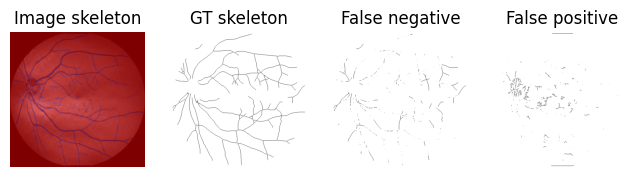

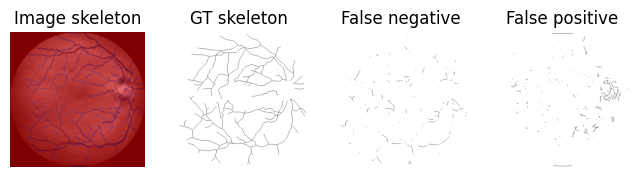

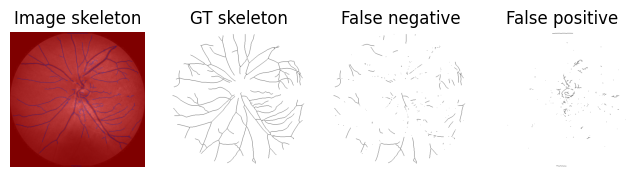

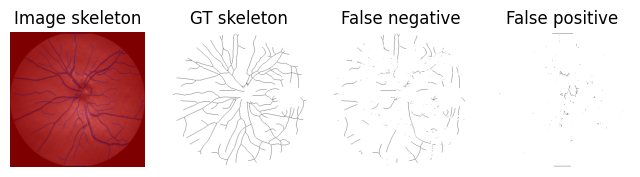

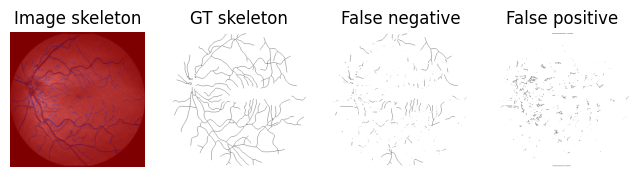

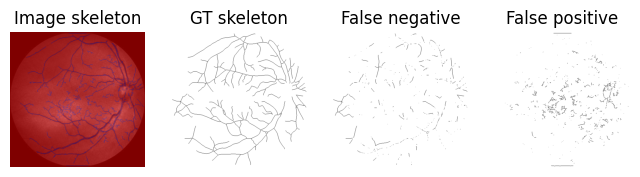

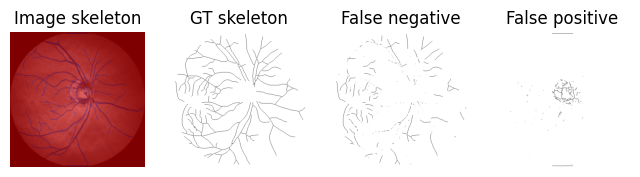

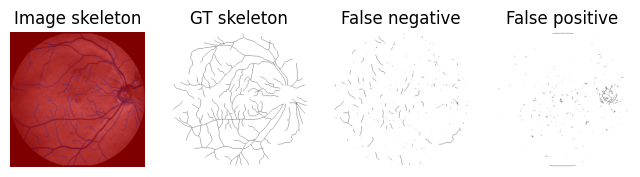

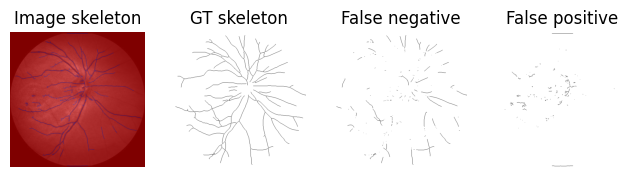

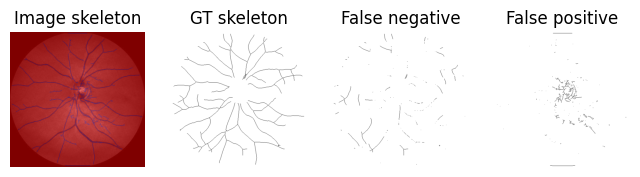

        Img1  Img2  Img3  Img4  Img5  Img6  Img7  Img8  Img9  Img10  Mean Performance  Std Performance
Preci   0.75  0.78  0.83  0.91  0.71  0.67  0.81  0.81  0.84   0.75              0.79             0.06
Recall  0.73  0.82  0.68  0.66  0.66  0.72  0.60  0.74  0.68   0.76              0.71             0.06


In [25]:
run_eval()